In [1309]:
from itertools import product
from numpy import dot, exp, mgrid, pi, ravel, square, uint8, zeros
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import imageio

### DATA INPUT

In [1310]:
img = cv2.imread(r"img/plane.bmp")

In [1311]:
def rgb2gray(img) :
    return dot(img[..., :3], [0.2989, 0.5870, 0.1140])

### GAUSSIAN FILTER

In [1312]:
# def gen_gaussian_kernel(k_size, sigma):
#     center = k_size // 2
#     x, y = mgrid[0 - center : k_size - center, 0 - center : k_size - center]
#     g = 1 / (2 * pi * sigma) * exp(-(square(x) + square(y)) / (2 * square(sigma)))
#     return g

In [1313]:
# def gaussian_filter(image, k_size, sigma):
#     height, width = image.shape[0], image.shape[1]
#     # dst image height and width
#     dst_height = height - k_size + 1
#     dst_width = width - k_size + 1

#     # im2col, turn the k_size*k_size pixels into a row and np.vstack all rows
#     image_array = zeros((dst_height * dst_width, k_size * k_size))
#     row = 0
#     for i, j in product(range(dst_height), range(dst_width)):
#         window = ravel(image[i : i + k_size, j : j + k_size])
#         image_array[row, :] = window
#         row += 1

#     #  turn the kernel into shape(k*k, 1)
#     gaussian_kernel = gen_gaussian_kernel(k_size, sigma)
#     filter_array = ravel(gaussian_kernel)

#     # reshape and get the dst image
#     dst = dot(image_array, filter_array).reshape(dst_height, dst_width).astype(uint8)

#     return dst

In [1314]:
gray = rgb2gray(img)
gray = np.float32(gray)
# gaussian3x3 = gaussian_filter(gray, 3, sigma=1)
gaussian3x3 = ndimage.gaussian_filter(gray, sigma = 1.0)
cv2.imwrite('blur2.jpeg', gaussian3x3)

True

In [1315]:
#===============================================
# ==================NDIMAGE=====================
#===============================================
# blur_img = ndimage.gaussian_filter(gray, sigma = 1.0)
# cv2.imwrite('savedimage.jpeg', blur_img) 


### GRADIENT

#### Gaussian Gradient

In [1316]:
# gauss_x = gen_gaussian_kernel(3,1)
# gauss_y = np.transpose(gauss_x)*-1
# def gradient_x(img) :
#     grad_img = ndimage.convolve(img, gauss_x)
#     return grad_img/np.max(grad_img)

# def gradient_y(img) :
#     grad_img = ndimage.convolve(img, gauss_y)
#     return grad_img/np.max(grad_img)

#### Sobel Gradient

In [1317]:
def gradient_x(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
    return grad_img/np.max(grad_img)

def gradient_y(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))
    return grad_img/np.max(grad_img)

In [1318]:
x_grad = gradient_x(gaussian3x3)
y_grad = gradient_y(gaussian3x3)

### AUTOCORRELATION MATRIX

In [1319]:
xx_grad = x_grad * x_grad
yy_grad = y_grad * y_grad
xy_grad = x_grad * y_grad

### FIND CORNERS

#### Constants

In [1320]:
tuple_data = []
k =0.04
max=0
ratio = 0.001

#### Window compute corners

In [1321]:
for i in range(1, int(img.shape[0] - 1)) :
    for j in range(1, int(img.shape[1] - 1)) :
        window_x = xx_grad[i-4 : i+5 , j-4 : j+5]
        window_y = yy_grad[i-4 : i+5 , j-4 : j+5]
        window_xy = xy_grad[i-4 : i+5 , j-4 : j+5]
        sum_xx = np.sum(window_x)
        sum_yy = np.sum(window_y)
        sum_xy = np.sum(window_xy)
        determinant = (sum_xx * sum_yy) - (sum_xy * sum_xy)
        trace = sum_xx + sum_yy
        R = determinant - (k * trace * trace)
        tuple_data.append((i, j, R))
        if(R > max) :
            max = R
print(max)

78.81159993248002


### NON MAXIMUM SUPPRESSION

9235
42


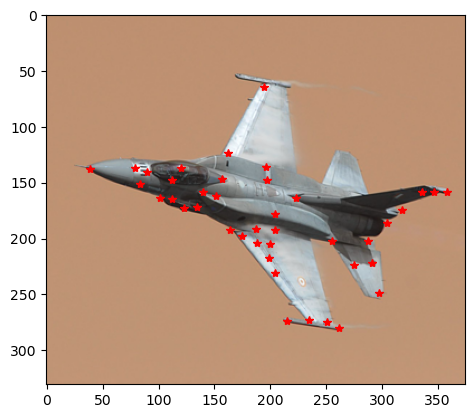

In [1322]:
output_path = "/output/"
L = []
thres_ratio = ratio
threshold = thres_ratio * max
for res in tuple_data :
    i, j, R = res
    if R > threshold :
        L.append([i, j, R])

sorted_L = sorted(L, key = lambda x: x[2], reverse = True)
final_L = [] #final_l contains list after non maximal suppression
final_L.append(sorted_L[0][:-1])
dis = 10
xc, yc = [], []
for i in sorted_L :
    for j in final_L :
        if(abs(i[0] - j[0] <= dis) and abs(i[1] - j[1]) <= dis) :
            break
    else :
        final_L.append(i[:-1])
        xc.append(i[1])
        yc.append(i[0])
print(len(sorted_L))
print(len(final_L))

#Print Final Image
corner_img = np.zeros(img.shape)
#(input_img.shape[0], input_img.shape[1], 3), dtype = np.uint8)

for i in final_L :
    y, x = i[0], i[1]
    corner_img[y][x] = 1

plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.plot(xc, yc, '*', color='red')

plt.savefig('res3.png')
plt.show()